<a href="https://colab.research.google.com/github/gabrielfernandorey/NLP/blob/main/Tecnicas-tradicionales/ITBA_NLP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NNMF

In [1]:
!git clone https://github.com/deeplearning-itba/dl_topics.git

Cloning into 'dl_topics'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 25 (delta 9), reused 22 (delta 6), pack-reused 0
Receiving objects: 100% (25/25), 9.88 MiB | 20.49 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [49]:
import warnings
warnings.filterwarnings('ignore')

In [176]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, MiniBatchNMF

SPANISH_STOPWORDS = list(pd.read_csv('data/spanish_stop_words.csv' )['stopwords'].values)

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(6, 5, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.tick_params(axis="both", which="major", labelsize=10)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [116]:
df = pd.read_parquet('data/df_joined_2024-04-01 00_00_00.parquet')

In [117]:
df[:2]

,Asset Name,Author Id,Author Name,Keyword Id,Keyword Name,Entity Id,Entity Name,Media Group Id,Media Group Name,Impact,...,in__text,out__entities,out__potential_entities,predicted_at_entities,out__keywords_sorted,predicted_at_keywords,start_time_utc,start_time_local,truncated_text,title_and_text
Asset Id,,,,,,,,,,,,,,,,,,,,,
105628101,Elecciones en Venezuela: María Corina Machado ...,36192,Infobae,1932002 | 417739 | 1687638 | 36187 | 7476 | 50...,"[falsas conspiraciones armadas, sustituta, det...",219925 | 210613 | 219770 | 36424 | 1129437,"[Nicolás Maduro, Jorge Rodríguez, Marcelo Ebra...",0,,7406333,...,Fotografía de archivo de la líder antichavista...,"[Nicolás Maduro, Marcelo Ebrard, Jorge Rodrígu...","[Jorge Rodríguez, Nicolás Maduro, Rayner Peña ...",2024-04-02 08:11:57.825777,"[elecciones presidenciales, candidatura presid...",2024-04-02 08:17:44.372891+00:00,2024-04-02,2024-04-01 21:00:00,Fotografía de archivo de la líder antichavista...,Elecciones en Venezuela: María Corina Machado ...
105628367,El populismo derivó en que los argentinos fina...,36192,Infobae,16544 | 1828 | 13482 | 1932318 | 1704643,"[crecimiento, impuestos, dólares, descomunal t...",1128732,[Reuters],0,,7406333,...,El argentino sabe que su moneda de ahorro es e...,[Reuters],"[De, AP, Reuters]",2024-04-02 08:25:15.803497,"[suficiente ahorro interno, descomunal tasa, d...",2024-04-02 08:32:06.638090+00:00,2024-04-02,2024-04-01 21:00:00,El argentino sabe que su moneda de ahorro es e...,El populismo derivó en que los argentinos fina...


In [118]:
df['in__title']

Asset Id
105628101    Elecciones en Venezuela: María Corina Machado ...
105628367    El populismo derivó en que los argentinos fina...
105629611    Día de los veteranos de Malvinas: el impacto y...
105629617    La revolución del efectivo: la Generación Z re...
105628730    El galante gesto de Diego Maradona con Mariana...
                                   ...                        
105641179    Cuánto cuesta ver a la Selección Argentina en ...
105593608    Javier Milei contra Estela de Carlotto: "Pidió...
105580130    Comercios en Córdoba: cayó 20.9% las ventas po...
105640664    Milei homenajeó a los héroes de Malvinas y con...
105580630    Subtes: reabrió la estación Facultad de Medici...
Name: in__title, Length: 3104, dtype: object

In [26]:
SPANISH_STOPWORDS[:10]

['a',
 'actualmente',
 'adelante',
 'además',
 'afirmó',
 'agregó',
 'ahora',
 'ahí',
 'al',
 'algo']

In [119]:
doc_array =  list(df['in__title'])
doc_array[:5]

['Elecciones en Venezuela: María Corina Machado pidió más apoyo de Noruega para garantizar unas presidenciales libres',
 'El populismo derivó en que los argentinos financien el crecimiento de los países desarrollados',
 'Día de los veteranos de Malvinas: el impacto y las secuelas del trauma psíquico en los excombatientes',
 'La revolución del efectivo: la Generación Z redescubre el dinero antiguo para evitar la bancarrota moderna',
 'El galante gesto de Diego Maradona con Mariana A: "Lo que hizo solo habla de su generosidad"']

In [28]:
import re

def clean_text(doc_array):
    REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
    REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")
    tempArr = []
    for line in doc_array:
        # remove puctuation
        tmpL = REPLACE_NO_SPACE.sub("", line.lower()) # Transformación en minúscula de los tweets
        tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
        tempArr.append(tmpL)
    return tempArr

In [120]:
doc_array_clean = clean_text(doc_array)
doc_array_clean[:5]

['elecciones en venezuela maría corina machado pidió más apoyo de noruega para garantizar unas presidenciales libres',
 'el populismo derivó en que los argentinos financien el crecimiento de los países desarrollados',
 'día de los veteranos de malvinas el impacto y las secuelas del trauma psíquico en los excombatientes',
 'la revolución del efectivo la generación z redescubre el dinero antiguo para evitar la bancarrota moderna',
 'el galante gesto de diego maradona con mariana a lo que hizo solo habla de su generosidad']

In [121]:
vectorizer = CountVectorizer(
                    tokenizer=None,
                    token_pattern=r'(?u)\b\w\w+\b',
                    encoding ='utf-8',
                    ngram_range=(1, 2),
                    max_df=0.9, # significa que cualquier término que aparezca en más del 90% de los documentos será ignorado.
                    #min_df=2,
                    stop_words=SPANISH_STOPWORDS,
                    # vocabulary=all_tokens,
)

In [122]:
vectorizer.fit(doc_array_clean)

CountVectorizer(max_df=0.9, ngram_range=(1, 2),
                stop_words=['a', 'actualmente', 'adelante', 'además', 'afirmó',
                            'agregó', 'ahora', 'ahí', 'al', 'algo', 'alguna',
                            'algunas', 'alguno', 'algunos', 'algún',
                            'alrededor', 'ambos', 'ampleamos', 'ante',
                            'anterior', 'antes', 'apenas', 'aproximadamente',
                            'aquel', 'aquellas', 'aquellos', 'aqui', 'aquí',
                            'arriba', 'aseguró', ...])

In [123]:
vectorizer.get_feature_names_out()

array(['01', '01 abril', '081', ..., 'único', 'único líder', 'único une'],
      dtype=object)

In [124]:
tfidf = TfidfVectorizer(
                    tokenizer=None,
                    token_pattern=r'(?u)\b\w\w+\b',
                    encoding ='utf-8',
                    ngram_range=(1, 2),
                    max_df=0.9, # significa que cualquier término que aparezca en más del 90% de los documentos será ignorado.
                    #min_df=2,
                    stop_words=SPANISH_STOPWORDS,
                    # vocabulary=all_tokens,
                    )

In [125]:
tfidf = tfidf.fit_transform(doc_array_clean)

In [126]:
tfidf.shape

(3104, 22650)

In [142]:
n_topics = 30
nmf = NMF(n_topics)
doc_topics = nmf.fit_transform(tfidf)

In [143]:
doc_topics.shape

(3104, 30)

In [144]:
nmf.components_.shape

(30, 22650)

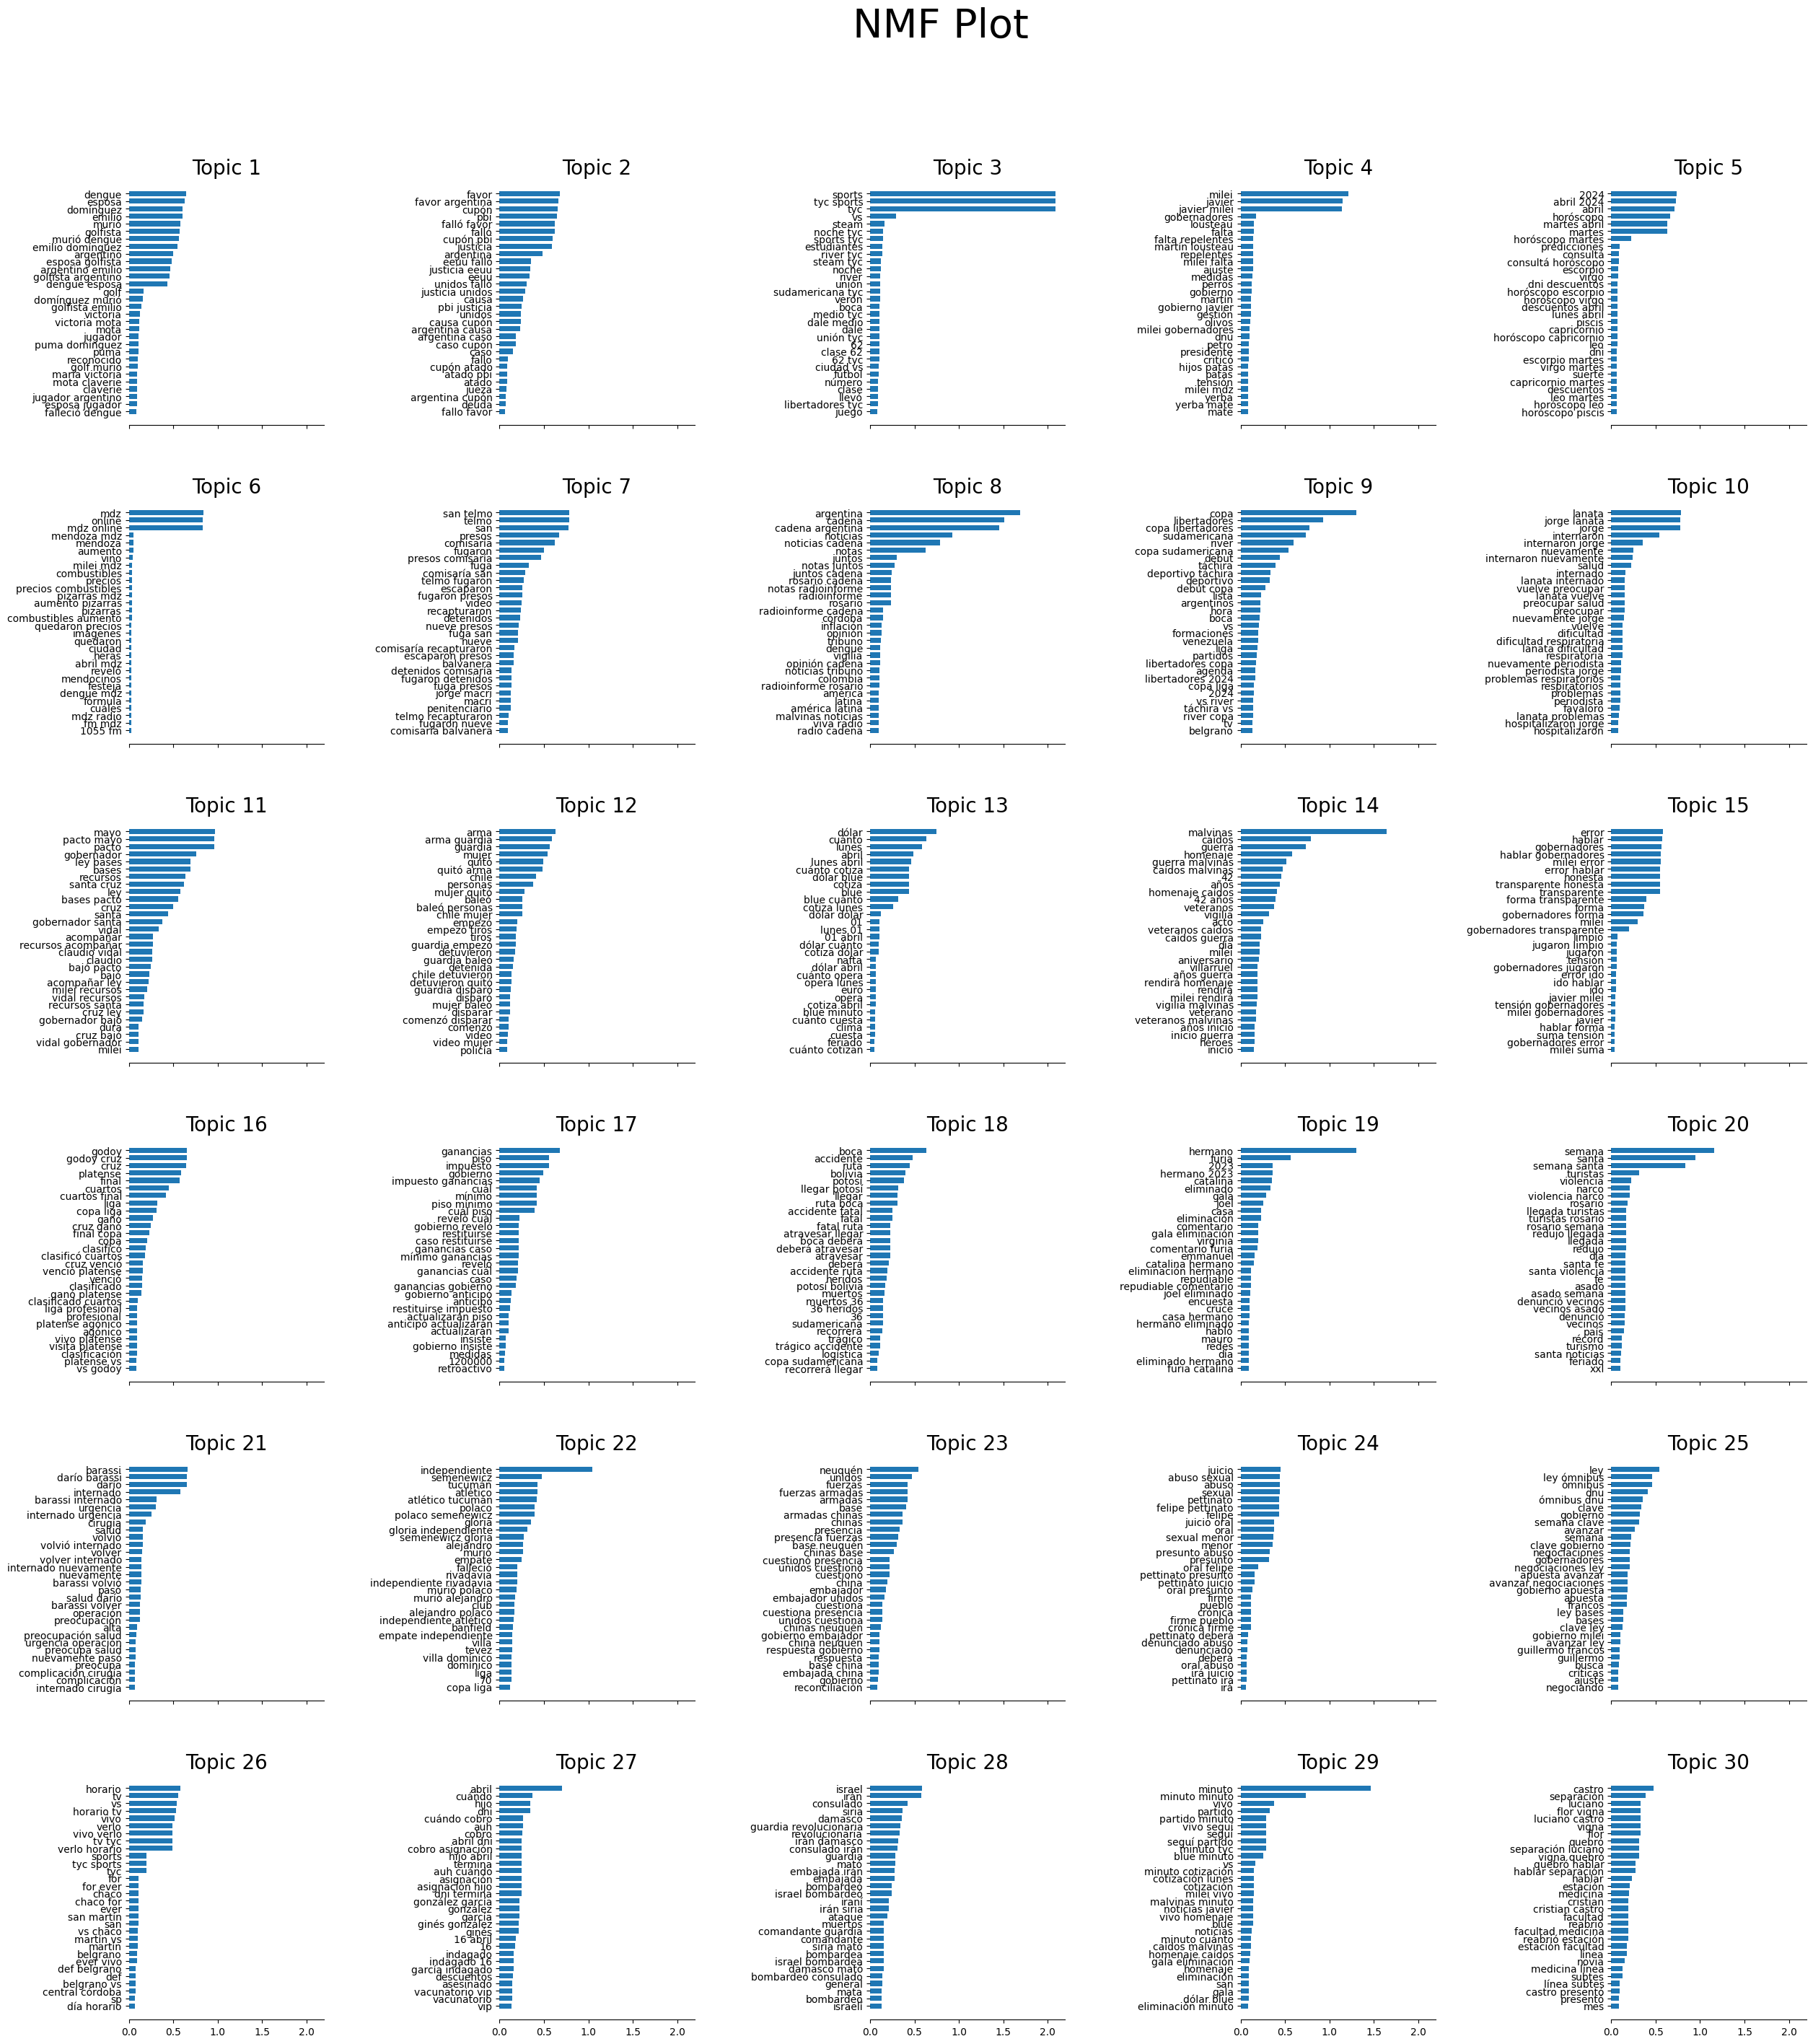

In [177]:
plot_top_words(
                nmf,
                vectorizer.get_feature_names_out(),
                n_topics,
                'NMF Plot'
            )

In [131]:
doc_topics.shape

(3104, 15)

In [167]:
def obtener_id_docs_por_contenido(texto):

    registros_title = df['in__title'][df['in__title'].str.contains(texto, case=False, na=False) ]
    registros_text = df['in__text'][df['in__text'].str.contains(texto, case=False, na=False) ]
    registros = registros_title + registros_text
    numeros_de_registro = registros.index.tolist()
    for i in numeros_de_registro:
        print(f"{i} {df.loc[i]['in__title']}")

    posiciones_orden = [df.index.get_loc(i) for i in numeros_de_registro]
    print(posiciones_orden)
    return posiciones_orden



In [180]:
# idx: posicion
def obtener_topico_por_idx(idx):
    print(f"Id: {idx}")
    print(f"Titulo: {doc_array[idx]}")
    print(f"Topico: {doc_topics[idx].argmax()+1}")
    print(f"Prob: {round(doc_topics[idx][doc_topics[idx].argmax()],4)}")
    return

In [202]:
# id: id de noticia
def obtener_topico_por_ID(id):
    print(f"ID: {id} {df.loc[id]['in__title']}")
    idx = df.index.get_loc(id)
    print(f"Topico: {doc_topics[idx].argmax()+1}")
    print(f"Prob: {round(doc_topics[idx][doc_topics[idx].argmax()],4)}")
    return

In [203]:
obtener_topico_por_ID(105628730)

ID: 105628730 El galante gesto de Diego Maradona con Mariana A: "Lo que hizo solo habla de su generosidad"
Topico: 18
Prob: 0.0043


In [171]:
idx = obtener_id_docs_por_contenido("galante gesto")

105628730 El galante gesto de Diego Maradona con Mariana A: "Lo que hizo solo habla de su generosidad"
[4]


In [179]:
for i in idx:
    obtener_topico_por_idx(i)

Id: 4
Titulo: El galante gesto de Diego Maradona con Mariana A: "Lo que hizo solo habla de su generosidad"
Topico: 18
Prob: 0.0043


In [174]:
# Probabilidades mayores a
valores_mayores_a = doc_topics[doc_topics > 0.5]
valores_mayores_a

array([0.58547283, 0.57552044, 0.52476056, 0.52476056, 0.51380065,
       0.55085315, 0.51915328, 0.58373337, 0.51189423, 0.51704728,
       0.51915328, 0.55085315, 0.51915328, 0.51704728, 0.58547283,
       0.54674924, 0.58373337, 0.51915328, 0.51185353, 0.51189423,
       0.55126937, 0.58547283, 0.52476056, 0.54674924])

In [175]:
# indices mayores a (pos, col(o topico))
indices_mayores_a = np.where(doc_topics > 0.5)

# Convertir los índices en una lista de tuplas (opcional)
indices_mayores_a_lista = list(zip(indices_mayores_a[0], indices_mayores_a[1]))
print(indices_mayores_a_lista)

[(196, 29), (393, 23), (460, 17), (519, 17), (587, 12), (647, 24), (673, 14), (680, 23), (847, 22), (1164, 12), (1258, 14), (1261, 24), (1499, 14), (1526, 12), (1615, 29), (1879, 22), (1977, 23), (2043, 14), (2220, 23), (2255, 22), (2321, 29), (2368, 29), (2578, 17), (3067, 22)]
